# Decision models homework 5, yee-haw!

In [1]:
# Rustle up some asynchronous tensor manipulation, partner!
import jax
from jax import numpy as np

In [2]:
import grub

/data/home/will/.conda/envs/will-gpu/lib/python3.8/site-packages/jax/lax/lax.py:6198: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/data/home/will/.conda/envs/will-gpu/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
# Rustle up some grub there, partner!
cowboy_details = grub.rustle()

# add joke about horse
clue_about_maiden_whereabouts = jax.random.PRNGKey(1)
clue_about_maiden_mood = jax.random.PRNGKey(2)
lookin_for_maidens = jax.random.uniform(clue_about_maiden_whereabouts, shape=(cowboy_details.n_cowboys, 20), dtype=jax.numpy.float32)
maiden_mood = jax.random.normal(clue_about_maiden_mood, shape=(cowboy_details.n_cowboys, 20), dtype=jax.numpy.float32)

In [4]:
# Dont squat with your spurs on!
@jax.jit
def rescue_maiden(luck, maiden_mood):
    did_we_rescue_the_maiden = luck < cowboy_details.cowgirl_needs_rescuing_prob * cowboy_details.cowgirl_rescued_prob
    maiden_gratitude = cowboy_details.gratitude_mean + cowboy_details.gratitude_std * maiden_mood
    return maiden_gratitude*did_we_rescue_the_maiden
    
    
@jax.jit
def initiate_adventure(do_luck_be_on_our_side, is_it_that_time_of_the_month):
    return jax.vmap(rescue_maiden)(do_luck_be_on_our_side, is_it_that_time_of_the_month)

In [5]:
our_adventure_was_great = initiate_adventure(do_luck_be_on_our_side=lookin_for_maidens, is_it_that_time_of_the_month = maiden_mood)

#### A) 

In [6]:
our_adventure_was_great.sum(axis=1).mean().item()

119.14285278320312

In [7]:
we_rescued_many = our_adventure_was_great.sum(axis=1).std() / (len(our_adventure_was_great)**(1/2))

# googled the z value for 95% confidence - 1.96, thanks google very cool 
we_rescued_many *= 1.96

#### B) 

In [8]:
print(our_adventure_was_great.sum(axis=1).mean()+we_rescued_many)
print(our_adventure_was_great.sum(axis=1).mean()-we_rescued_many)

120.09924
118.18646


#### C) 

In [9]:
extra_lucky = np.mean(our_adventure_was_great.sum(axis=1)>200).item()
extra_lucky

0.055799998342990875

### D)

In [10]:
interval_bounds = 1.65 * np.sqrt(extra_lucky*(1-extra_lucky) / len(our_adventure_was_great))
print(extra_lucky+interval_bounds)
print(extra_lucky-interval_bounds)

0.059587326
0.05201267


In [11]:
# Rewrite in cowboy theme later

# 9/26 update - i got too tired to rewrite in cowboy theme. if you have to deduct points for this, i understand

In [35]:
# dim 1 is booking limit 
show = jax.random.uniform(clue_about_maiden_whereabouts, shape=(cowboy_details.n_cowboys, 56), dtype=jax.numpy.float32)

In [36]:
@jax.jit
def simulation(probability):
    booking_limit = probability.shape[0]
    showed_up = booking_limit - np.sum(probability < 0.1).astype(np.float32)

    revenue = 105*booking_limit
    n_overbooked = jax.lax.max(showed_up-50., 0.)

    revenue -= (105+150)*n_overbooked

    return revenue - showed_up*45


In [37]:
@jax.jit
def sim_1d(show):
    return jax.vmap(simulation)(show)

### b)

In [38]:
# its slow i blame ghosts
%%timeit
sim = sim_1d(show)
sim.mean()

593 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### c)

In [16]:
interval_bounds = 1.96*sim.std()/(len(sim))**(1/2)

In [17]:
print(sim.mean()+interval_bounds) 
print(sim.mean()-interval_bounds)

3341.8098
3324.652


### d)

In [18]:
over_3800 = (sim > 3800.).astype(np.float64).mean()
over_3800

/data/home/will/.conda/envs/will-gpu/lib/python3.8/site-packages/jax/lax/lax.py:6198: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


DeviceArray(0.0504, dtype=float32)

### e)

In [19]:
interval_bounds = 1.96 * np.sqrt(over_3800*(1-over_3800) / len(sim))

In [20]:
print(over_3800+interval_bounds)
print(over_3800-interval_bounds)

0.054687873
0.046112128


### f)

In [21]:
from functools import partial
@partial(jax.jit, static_argnums=(0,))
def sim_2d(i):
    show = jax.random.uniform(clue_about_maiden_whereabouts, shape=(cowboy_details.n_cowboys, i), dtype=jax.numpy.float32)
    sim = sim_1d(show)
    return sim.mean()

@partial(jax.jit, static_argnums=(0,))
def sim_2d_actual(range):
    return jax.vmap(sim_2d)(range)

In [22]:
sim_2d_actual(np.arange(50, 60))

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (DeviceArray(10000, dtype=int32), Traced<ShapedArray(int32[])>with<BatchTrace(level=0/1)>
  with val = DeviceArray([50, 51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int32)
       batch_dim = 0).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.

In [23]:
def spongebob_mock(s):
    ret = ""
    i = False  # capitalize
    for char in s:
        if i:
            ret += char.upper()
        else:
            ret += char.lower()
        if char != ' ':
            i = not i
    return ret

In [24]:
spongebob_mock('Shapes must be 1D sequences of concrete values of integer type, got (DeviceArray(10000, dtype=int32), Traced<ShapedArray(int32[])>with<BatchTrace(level=0/1)> with val = DeviceArray([50, 51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int32) batch_dim = 0).')

'sHaPeS mUsT bE 1D sEqUeNcEs Of CoNcReTe VaLuEs Of InTeGeR tYpE, GoT (DeViCeArRaY(10000, DtYpE=InT32), tRaCeD<ShApEdArRaY(InT32[])>wItH<BaTcHtRaCe(lEvEl=0/1)> WiTh VaL = DeViCeArRaY([50, 51, 52, 53, 54, 55, 56, 57, 58, 59], DtYpE=InT32) BaTcH_DiM = 0).'

In [25]:
spongebob_mock('If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.')

'iF uSiNg `jIt`, TrY uSiNg `sTaTiC_ArGnUmS` Or ApPlYiNg `jIt` tO sMaLlEr SuBfUnCtIoNs.'

<img src="spongebob_mock.jpg">

In [31]:
%%timeit
jax_lost_my_love = []
this_stupid_for_loop = range(40, 70)

for each_stupid_element in this_stupid_for_loop: 
    show = jax.random.uniform(clue_about_maiden_whereabouts, shape=(cowboy_details.n_cowboys, each_stupid_element), dtype=jax.numpy.float32)
    sim = sim_1d(show)
    jax_lost_my_love.append(sim.mean().copy())

217 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<img src="we_lose.jpg">

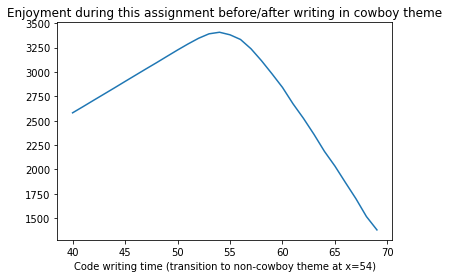

In [40]:
import matplotlib.pyplot as plt
plt.plot(this_stupid_for_loop, jax_lost_my_love)
plt.title('Enjoyment during this assignment before/after writing in cowboy theme')
plt.xlabel('Code writing time (transition to non-cowboy theme at x=54)')
plt.show()

In [33]:
list(this_stupid_for_loop)[np.argmax(np.array(jax_lost_my_love))]

54